\noindent __Hydrograph Development Notebooks__ 
\parskip = \baselineskip

\noindent __Breach Hydrographs, Whitney Point, NY__
\parskip = \baselineskip

\noindent PYTHON
\parskip = \baselineskip

\noindent Overview: This notebook was created to document the development of breach hydrographs using historical flow data for two locations along the levee at [Whitney Point, NY](https://www.google.com/maps/place/Whitney+Point,+NY+13862/@42.3282061,-75.9682914,1409m/data=!3m1!1e3!4m5!3m4!1s0x89da58ea5fb75db9:0x5b668176f4c0b03d!8m2!3d42.3289625!4d-75.9677001). 

Updated 1.10.2017

# Develop a discharge hydrograph of the 1% storm for the main flooding source

## Exploratory Analysis
[Notebook](FirstLook_GageData.ipynb) developed to evaluate available gage data in the vicinity, plot available time series & qualitatively assess differences in hydrograph shapes.

## Discharge Hydrograph
Select the timeseries for the [highest recorded peak (2005)](https://nwis.waterdata.usgs.gov/ny/nwis/peak/?site_no=01509000&agency_cd=USGS) where [available instantaneous gage data](https://nwis.waterdata.usgs.gov/ny/nwis/uv?cb_00060=on&format=gif_default&site_no=01509000&period=&begin_date=2005-03-25&end_date=2005-04-15) exists. 

## Peak Discharge (1%)
Using Bulletin 17B procedures and the USGS PeakFQ software, the 1% Storm (peak flow) value was determined at the nearest applicable gage. 
\parskip = \baselineskip

[Input](https://raw.githubusercontent.com/Dewberry-RSG/HydrologyTools/master/nbs/peakfq/USGS01509520.inp)
\parskip = \baselineskip

[Output](https://raw.githubusercontent.com/Dewberry-RSG/HydrologyTools/master/nbs/peakfq/USGS01509520.PRT)
\parskip = \baselineskip

## Stretch the Hydrograph 
Stretch the hydrograph to the calculated peak flow.

\noindent *Details on the methodology for this are described in the [Proof of Concepts Document](https://github.com/Dewberry-RSG/HydrologyTools/blob/master/documentation/ProofofConceptHydrologyStudies.pdf). Implementation using Jupyter Notebooks for the proof of concept cases are available in the [Methodology Overview](MethodologyOverview.ipynb).*

## Stage Hydrograph

\noindent In order to convert the flow hydrograph to a stage hydrograph at any given location, a hydraulic analysis is necessary to properly account for differences in the cross-sectional area at different locations along the reach. For this study a 1D, Steady State model was used to simulate a Natural Valley scenario in the levee impact area. 

\noindent The geometry from this model was used to compute flows ranging from 1,000 cfs to 25,000 cfs in increments of 1,000 cfs. The results of these simulations were used to develop a rating curve at each area of interest to translate flow to stage. The image below is an example of the results at a cross section, illustrating how geometric differences at different flow levels may impact the resultant stage for a given reach. 

\noindent Note that the change in water surface elevation when the flow is constrained by the channel and the levee during overbank flow rises at a greater rate when compared with the unconstrained flow when conveyance occurs on both sides of the levee (natural valley).

![](Example.png)

## Breach Hydrograph

### Procedure to create Breach Hydrograph

__A__. Read in HEC-RAS data for the XS of interest & create a stage/discharge rating curve using computed flows.

__B__. Using the data from the rating curve in Part A, create a function (nth degree polynomial interpolation equation) to convert flow to stage.

__C__. Convert the 1% flow hydrograph created in Step 1 to a stage hydrograph using the rating curve function created in Part B.

__D__. Normalize the stage to 'feet above the breach point' using the stage hydrograph created in Part C and the breach elevation (head = 0 at breach point). 

__E__. Using the head above breach hydrograph created in Part D, calculate weir flow for (use the Standard Weir Equation, below) each timestep & write to file.  

__F__. Input weir flow hydrograph created in Part E into HEC-RAS unsteady flow file. 

#### The Standard Weir Equation: 
#### $\qquad$ $Q = CLH^{2/3}$
\parskip = \baselineskip

\noindent , Where:  
\parskip = \baselineskip

$\qquad$ __Q__ = Discharge (cfs) 
\parskip = \baselineskip

$\qquad$ __C__ = Weir coefficient (unitless) 
\parskip = \baselineskip

$\qquad$ __L__ = Weir crest length (ft)
\parskip = \baselineskip

$\qquad$ __H__ = Energy head over the weir crest (ft)
\parskip = \baselineskip


\noindent *From HEC-RAS Lateral Weir Coefficients, use the default Weir Coefficient of 2.0 (range is 1.5-2.6, given on page 3-50 of the [2D Users Manual](http://www.hec.usace.army.mil/software/hec-ras/documentation/HEC-RAS%205.0%202D%20Modeling%20Users%20Manual.pdf))*

In [14]:
import os
from glob import glob

from importlib import reload
import utils; reload(utils)
from utils import *
import ny_clean_nb; reload(ny_clean_nb)
from ny_clean_nb import *

import pandas as pd
import numpy as np
from scipy import interpolate 

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Flow hydrogaphs for the 1% chance storm: 
####  Read in gage data & develop base hydrograph

- Read in Base Hydrograph from [USGS Gage](https://waterdata.usgs.gov/usa/nwis/uv?site_no=01509000) & Scale to 1-pct using scale factor
- Manually Smooth the curve where needed
    
*See comment lines in [Helper Script](ny_clean_nb.py) for smoothing procedure.*

*Data for the falling limb of the April 2005 event was missing from the USGS database. To fill the missing data a third order polynomial interpolation was used to approximately mirror the rising limb.   

**Reading data from**

01509000_00060_dv.tsv
01509000_00060_iv.tsv
01509000_00065_iv.tsv
01509520_00065_iv.tsv
01511500_00065_iv.tsv




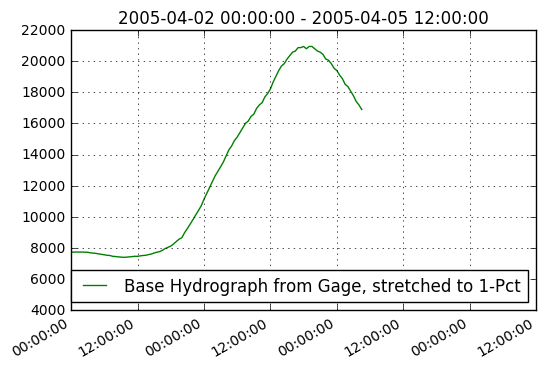

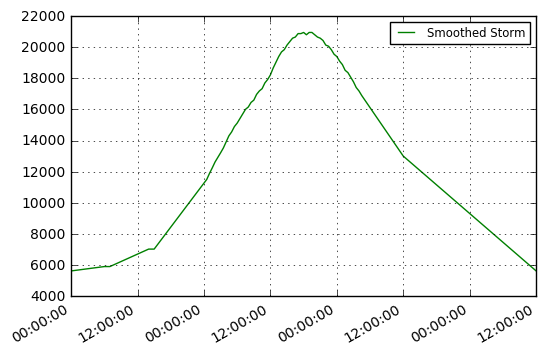

In [18]:
printbold('Reading data from')
gage_data, data_dir = initialize()
base_storm_1pct = init_base_hydro(gage_data)
smooth_storm = smooth_base_hydro(base_storm_1pct)

## Breach Location # 1:

__Upstream Location__

As described above, breach locations should be chosen at or very near a XS (or a XS added if not in the area of breaching) to get the stage discharge curve as accurate as possible.

<img src="https://raw.githubusercontent.com/Dewberry-RSG/HydrologyTools/master/images/43305.79_location_1.JPG" ,  width=900,height=800/>

#### Plots Summary (from top to bottom):

1. Stage/Discharge Rating curve at HEC-RAS Cross section shown above.
- 1% chance discharge hydrograph on the left, converted to stage on the right. In red is the elevation of the levee toe (invert of the hypothetical breach).
- 1% chance stage hydrograph on the left (limited to values above breaching threshold), converted to head over breach elevation in the center, final breach hydrograph (computed as described above) in cfs. 

NOTE: For this analysis, __*hypothetical breach locations*__ have been selected at 2 locations along the levee. There is no evidence that a breach is likely to occur at this location. 

**RAS Data for XS 43305.79**

**
Inflow Data for Breach Location: **

C:\Users\slawler\Repos\HydrologyTools\sample_data\WhitneyPoint_BreachData_43305.79_location_1.tsv


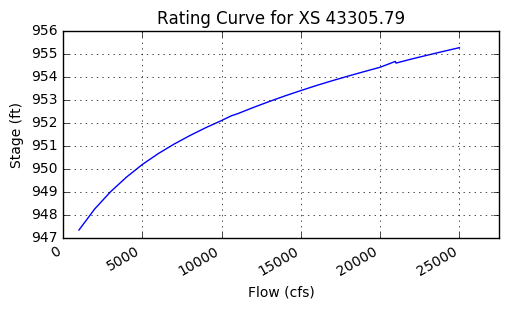

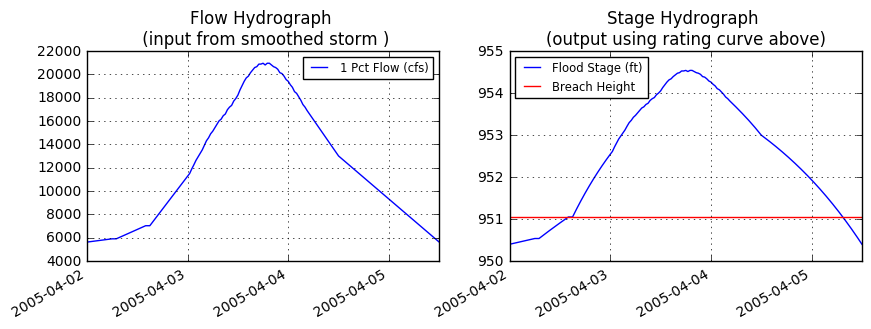

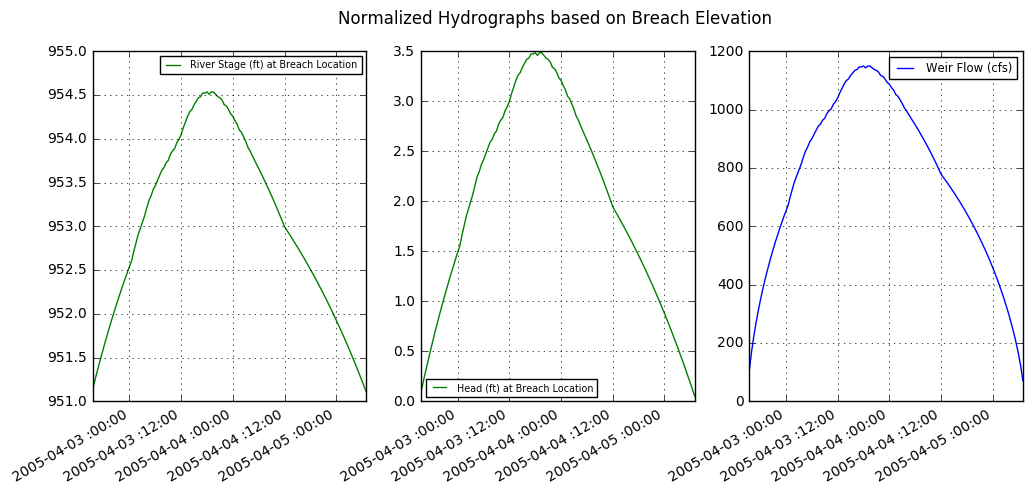

In [16]:
rasdata = r'p:\02\NY\Broome_Co_36007C\LAMP2\TECH\Analysis\Modeling\WorkingModels\Lisle_WhitPt\LAMPRAS\Lisle_WhitPt.p05.hdf'
data_dir = r'C:\Users\slawler\Repos\HydrologyTools\sample_data'
community = 'WhitneyPoint'
station = 43305.79
breach_point = 1
breach_height = 951.05
GetBreachFlow(smooth_storm, community, rasdata, station, breach_point, breach_height, data_dir, date_int = 12)

## Breach Location # 2:

__Downstream Location__

<img src="https://raw.githubusercontent.com/Dewberry-RSG/HydrologyTools/master/images/39847.10_location_2.JPG" ,  width=900,height=800/>

#### Plots Summary (from top to bottom):

1. Stage/Discharge Rating curve at HEC-RAS cross section shown above.
- 1% chance discharge hydrograph on the left, converted to stage on the right. In red is the elevation of the levee toe (invert of the hypothetical breach).
- 1% chance stage hydrograph on the left (limited to values above breaching threshold), converted to head over breach elevation in the center, final breach hydrograph (computed as described above) in cfs. 

NOTE: For this analysis, __*hypothetical breach locations*__ have been selected at 2 locations along the levee. There is no evidence that a breach is likely to occur at this location. 

**RAS Data for XS 39847.10**

**
Inflow Data for Breach Location: **

C:\Users\slawler\Repos\HydrologyTools\sample_data\WhitneyPoint_BreachData_39847.10_location_2.tsv


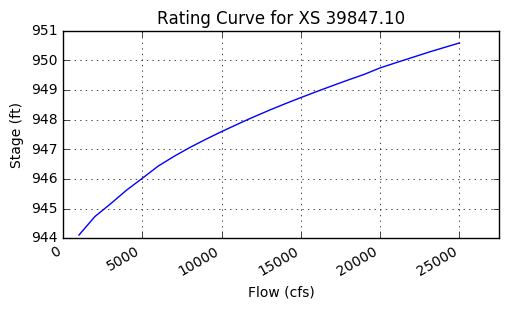

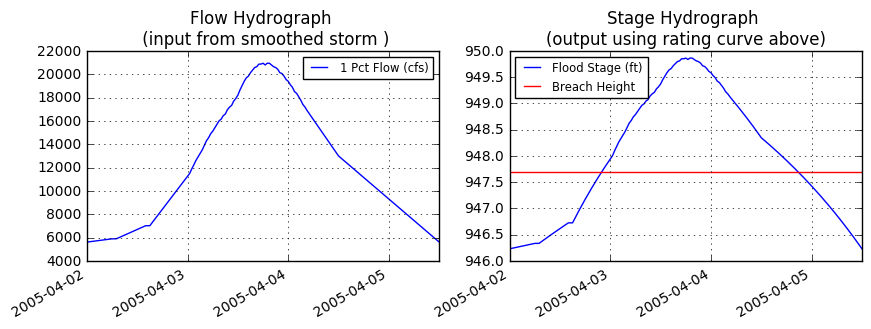

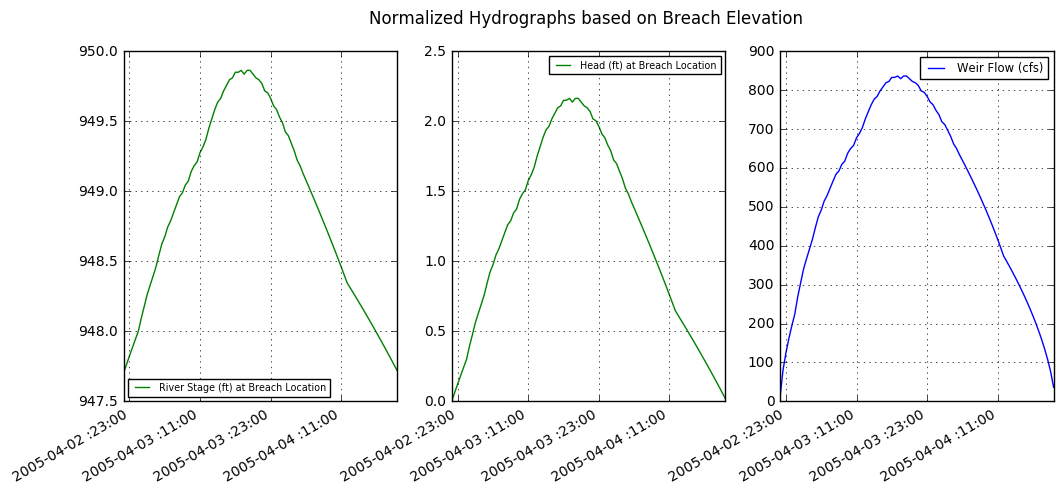

In [11]:
rasdata = r'p:\02\NY\Broome_Co_36007C\LAMP2\TECH\Analysis\Modeling\WorkingModels\Lisle_WhitPt\LAMPRAS\Lisle_WhitPt.p05.hdf'
community = 'WhitneyPoint'
station = str('39847.10')
breach_point = 2
breach_height = 947.70

GetBreachFlow(smooth_storm, community , rasdata, station, breach_point, breach_height, data_dir, date_int = 12)